In [1]:
%pylab inline

import numpy as np
import pandas as pd
import dask.dataframe as dd

print(np.__version__, pd.__version__)
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib
1.11.0 0.18.1


Read the 15 Gbyte dataframe located in a HDF5 data file into a dask dataframe.  This will allow us to do out of memory operations.

In [2]:
#file_path = "/global/u1/c/cwalter/"
file_path = "/global/project/projectdirs/lsst/cwalter/DC1-HDF5/"

df = dd.read_hdf(file_path+'Coadd_undithered.hdf', key='/*')

This will show us all of the columns of the dask dataframe

In [3]:
df.info();

<class 'dask.dataframe.core.DataFrame'>
Data columns (total 166 columns):
FLAGS1                                       uint64
FLAGS2                                       uint64
FLAGS3                                       int64
id                                           int64
coord_ra                                     float64
coord_dec                                    float64
parent                                       int64
deblend_nChild                               int64
deblend_psfCenter_x                          float64
deblend_psfCenter_y                          float64
deblend_psfFlux                              float64
base_GaussianCentroid_x                      float64
base_GaussianCentroid_y                      float64
base_NaiveCentroid_x                         float64
base_NaiveCentroid_y                         float64
base_SdssCentroid_x                          float64
base_SdssCentroid_y                          float64
base_SdssCentroid_xSigma           

Now do a dask operation and put the results (which will fit in memory) into a normal pandas data frame.  First specify which columns we would like.

In [4]:
requested_columns = ['patch', 'footprint', 'coord_ra','coord_dec', 
                     'base_PsfFlux_flux','base_PsfFlux_fluxSigma',
                     'modelfit_CModel_flux']

Have dask read the file and move it into a pandas dataframe with the columns we want.  Do the whole dataset and just patch 10,10.

In [5]:
%%time
selected = df[requested_columns].compute()
selected.shape

CPU times: user 1min 7s, sys: 42.8 s, total: 1min 50s
Wall time: 1min 52s


In [6]:
%%time
selected_patch = df.query("patch == \"'10,10'\"")[requested_columns].compute()
selected_patch.shape

CPU times: user 1min 15s, sys: 44.5 s, total: 1min 59s
Wall time: 1min 57s


Now let's calculate some validation quantities.

In [7]:
flux_mag0 = 63095734448.0194
magnitude = -2.5*log10(selected['base_PsfFlux_flux']/flux_mag0)

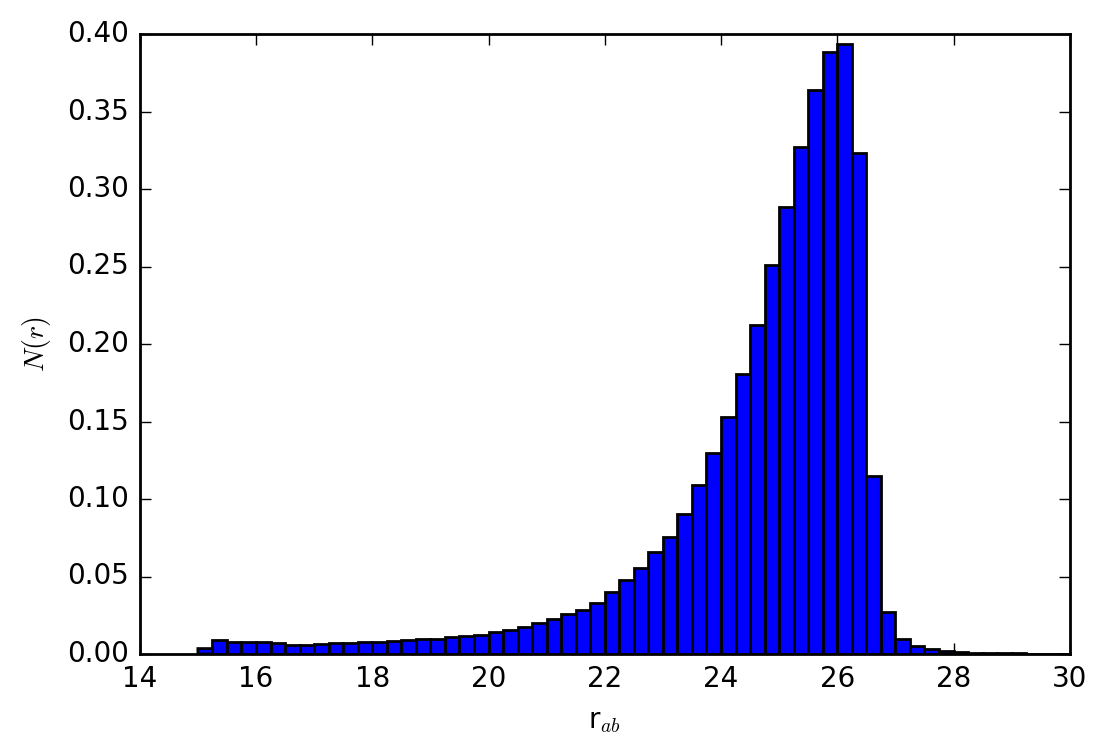

In [8]:
plt.hist(magnitude,range=(15,30),bins=60,normed=True)
plt.xlabel(r'r$_{ab}$')
plt.ylabel(r'$N(r)$')

Plot the sky locations.  First for the whole dataset:

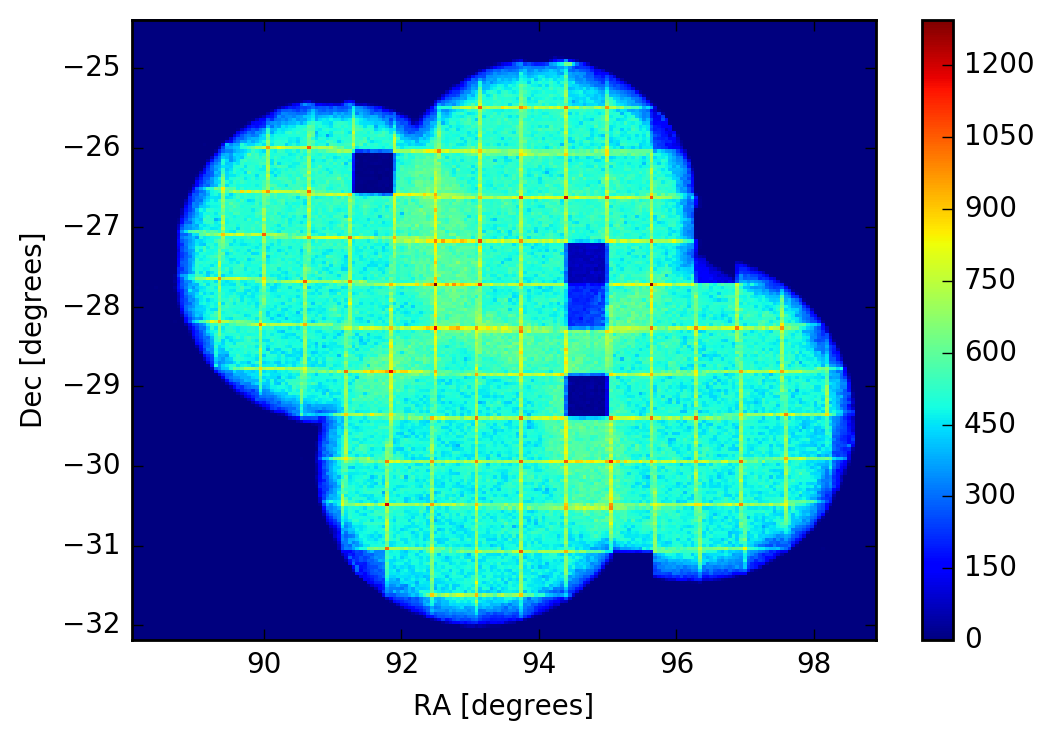

In [9]:
ra = selected['coord_ra']*180/pi
dec = selected['coord_dec']*180/pi

#plt.scatter(ra, dec, marker='.',color='k')
plt.hist2d(ra, dec, bins=200)
plt.xlabel('RA [degrees]')
plt.ylabel('Dec [degrees]')
plt.colorbar()

And now for just the selected patch 10,10

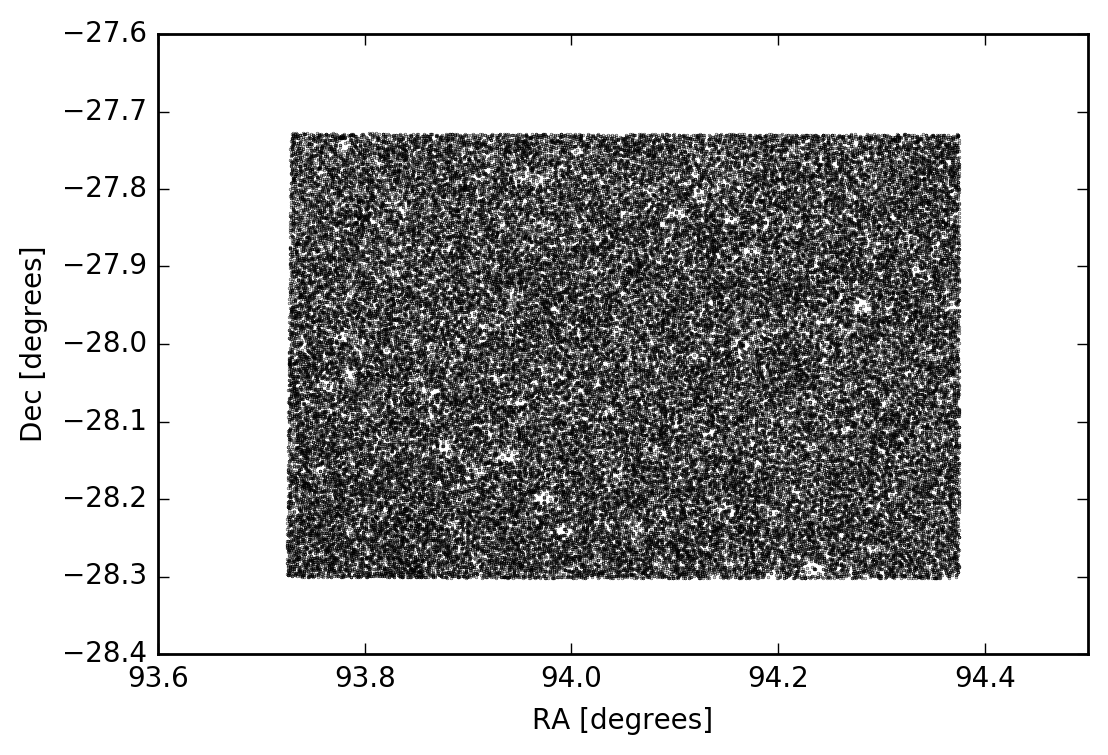

In [10]:
ra = selected_patch['coord_ra']*180/pi
dec = selected_patch['coord_dec']*180/pi

plt.scatter(ra, dec, marker='.', s=0.1, color='k')
#plt.hist2d(ra, dec, bins=200)
plt.xlabel('RA [degrees]')
plt.ylabel('Dec [degrees]')

Now let's overlay them!

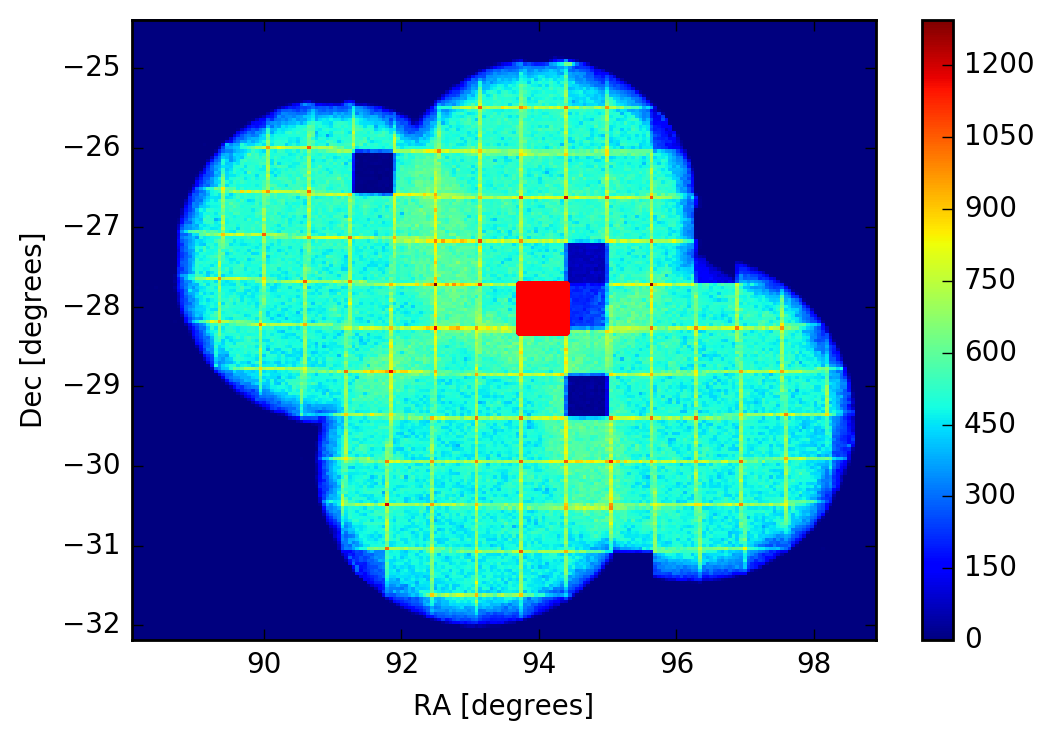

In [11]:
ra = selected['coord_ra']*180/pi
dec = selected['coord_dec']*180/pi

ra_patch = selected_patch['coord_ra']*180/pi
dec_patch = selected_patch['coord_dec']*180/pi

#plt.scatter(ra, dec, marker='.',color='k')
plt.hist2d(ra, dec, bins=200)
plt.xlabel('RA [degrees]')
plt.ylabel('Dec [degrees]')
plt.colorbar()

plt.scatter(ra_patch, dec_patch, marker='.',color='r')
#plt.hist2d(ra, dec, bins=200)
plt.xlabel('RA [degrees]')
plt.ylabel('Dec [degrees]')

Now we would like to plot a very simple single band star galaxy seperator.  This is based on the definition in:

http://www.sdss3.org/dr8/algorithms/classify.php

Which defines extended objects as those for which:

psfMag - cmodelMag > 0.145

In [12]:
flux_mag0 = 63095734448.0194
psfMag = -2.5*log10(selected['base_PsfFlux_flux']/flux_mag0)
cmodelMag = -2.5*log10(selected['modelfit_CModel_flux']/flux_mag0)

objectType = psfMag - cmodelMag

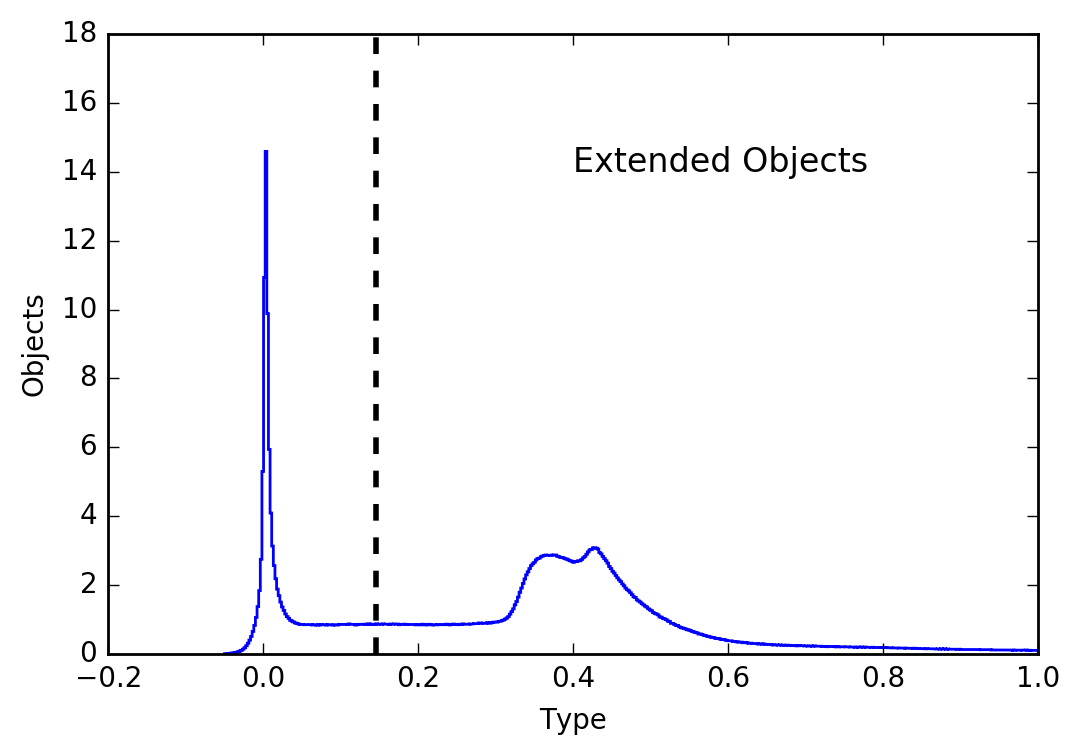

In [13]:
plt.hist(objectType, range=(-0.05,1.0), bins=500, histtype='step',normed=True)
plot([.145, .145], [0, 18], color='k', linestyle='--', linewidth=2)
text(0.4, 14, "Extended Objects", fontsize=12)
plt.xlabel("Type")
plt.ylabel("Objects")

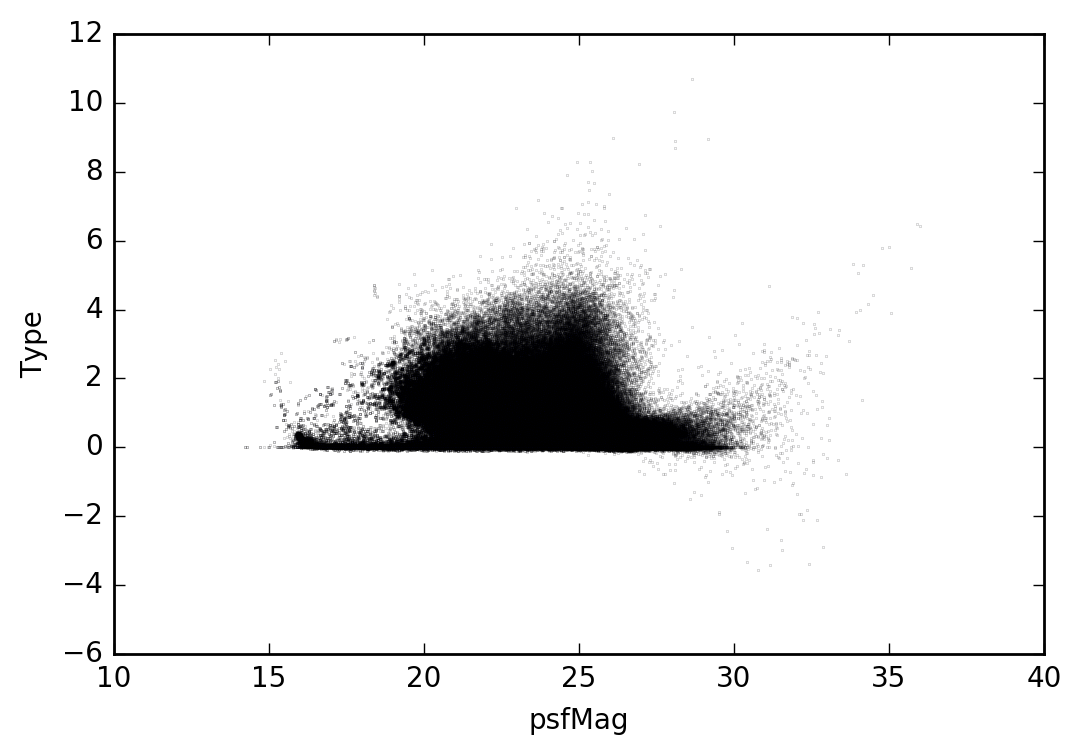

In [14]:
plt.scatter(psfMag, objectType, s=.01, marker=".")
plt.xlabel("psfMag")
plt.ylabel("Type")

#plt.xlim(19,  26)
#plt.ylim(-0.01, 0.10);

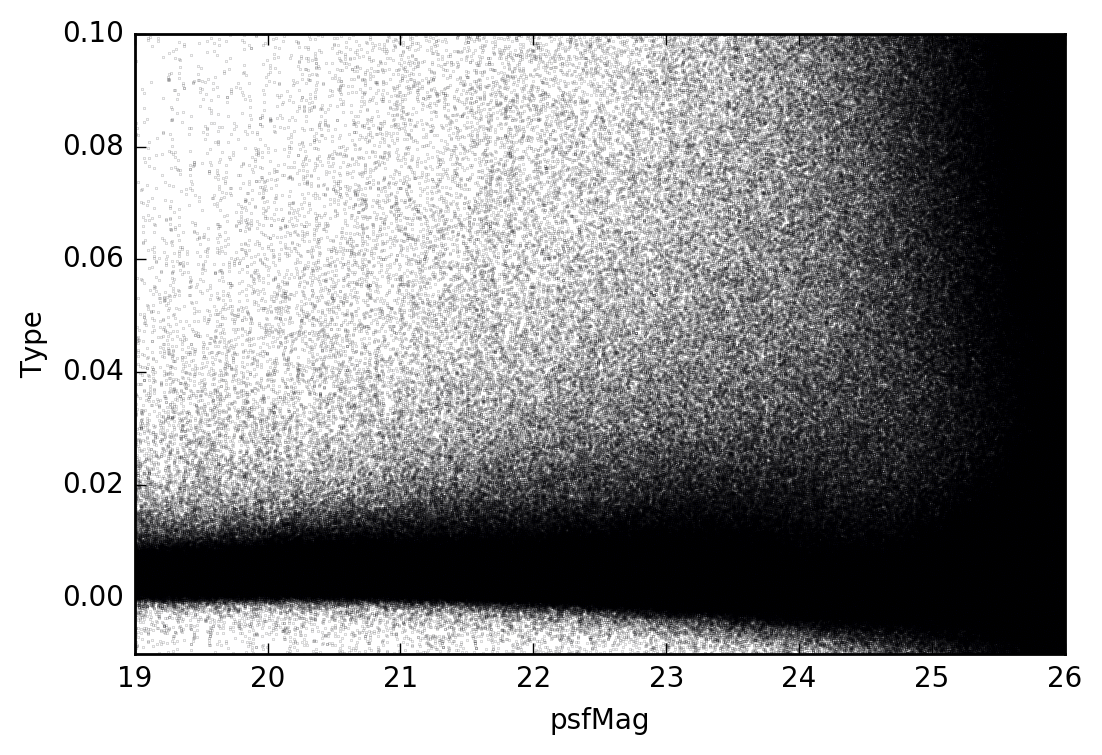

In [15]:
plt.scatter(psfMag, objectType, s=.01, marker=".")
plt.xlabel("psfMag")
plt.ylabel("Type")

plt.xlim(19,  26)
plt.ylim(-0.01, 0.10);